In [66]:
# Parametry dla eksperymentu

LENGTH = 500 # Długość sygnału
USE_FFT = True # Czy używać FFT

### Wczytanie datasetu

In [67]:
import numpy as np

DATASET_NAME = "FordA"

CLASS_NAMES = ["Abnormal", "Normal"]

with open(f"{DATASET_NAME}_TRAIN.txt", "r") as f:
    X_train = []
    y_train = []
    for line in f.readlines():
        line = line.strip().split("  ")
        class_id = int(float(line[0]))
        class_id = max(class_id, 0)
        data = np.array(line[1:], dtype=np.float64)[:LENGTH]
        X_train.append(data)
        y_train.append(class_id)

with open(f"{DATASET_NAME}_TEST.txt", "r") as f:
    X_test = []
    y_test = []
    for line in f.readlines():
        line = line.strip().split("  ")
        class_id = int(float(line[0]))
        class_id = max(class_id, 0)
        data = np.array(line[1:], dtype=np.float64)[:LENGTH]
        X_test.append(data)
        y_test.append(class_id)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

### Wizualizacja przebiegów

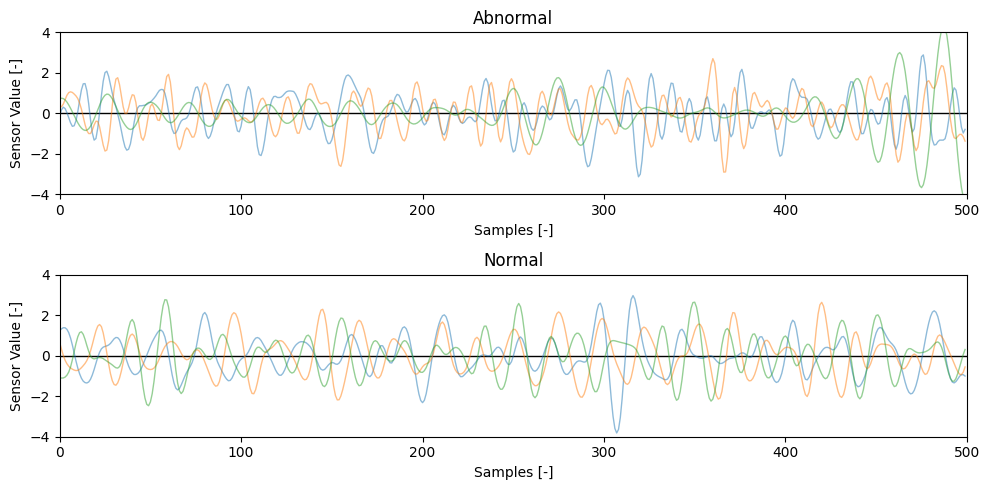

In [68]:
import matplotlib.pyplot as plt
import numpy as np

fig,axes = plt.subplots(nrows=len(CLASS_NAMES),figsize=(10,5))
for i,ax in enumerate(axes):
    ax.axhline(0, color='black', linestyle='-', linewidth=1)
    for j in range(3):
        index = np.where(y_test == i)[0][j]
        ax.plot(np.array(X_test[index], dtype=float), linewidth=1, alpha=0.5)
    ax.set_title(f"{CLASS_NAMES[i]}")
    ax.set_xlabel("Samples [-]")
    ax.set_ylabel("Sensor Value [-]")
    ax.set_xlim(0, LENGTH)
    ax.set_ylim(-4, 4)

plt.tight_layout()
plt.show()


### Analiza danych

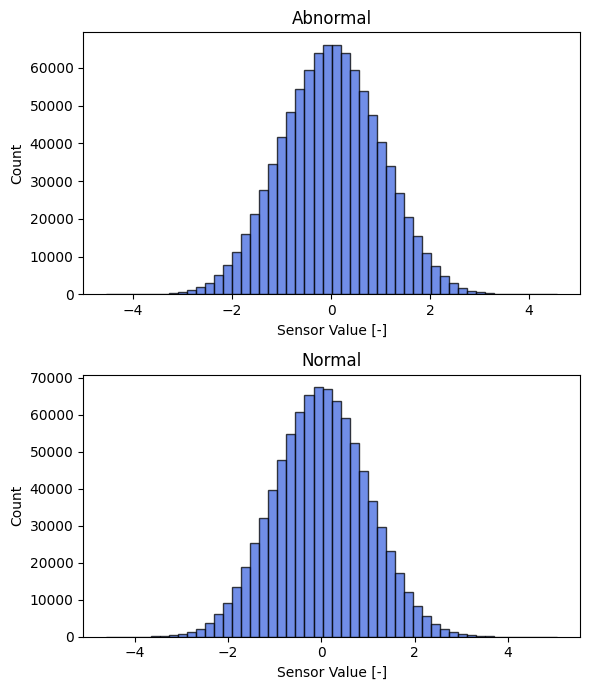

Class: Abnormal
	Mean: -0.000 (0.000)
	Std: 0.999 (0.000)
	Mean Abs: 0.802 (0.031)
	Std Abs: 0.594 (0.041)
	Max: 2.672 (0.397)
	Min: -2.679 (0.404)
Class: Normal
	Mean: -0.000 (0.000)
	Std: 0.999 (0.000)
	Mean Abs: 0.799 (0.029)
	Std Abs: 0.598 (0.038)
	Max: 2.725 (0.380)
	Min: -2.695 (0.392)


In [69]:
class_values = {}
class_stats = {}
for class_id in range(len(CLASS_NAMES)):
    class_values[class_id] = []
    class_stats[class_id] = {
        'mean': [],
        'mean-abs': [],
        'std': [],
        'std-abs': [],
        'max': [],
        'min': []
    }
    for index in np.where(y_train == class_id)[0]:
        class_values[class_id] += X_train[index].tolist()

        class_stats[class_id]['mean'].append(np.mean(X_train[index]))
        class_stats[class_id]['mean-abs'].append(np.mean(np.abs(X_train[index])))
        class_stats[class_id]['std'].append(np.std(X_train[index]))
        class_stats[class_id]['std-abs'].append(np.std(np.abs(X_train[index])))
        class_stats[class_id]['max'].append(np.max(X_train[index]))
        class_stats[class_id]['min'].append(np.min(X_train[index]))
    for key in class_stats[class_id]:
        class_stats[class_id][key] = np.mean(class_stats[class_id][key]), np.std(class_stats[class_id][key])

fig,axes = plt.subplots(nrows=len(CLASS_NAMES),figsize=(6,7))

for i,ax in enumerate(axes):
    ax.hist(class_values[i], bins=50, alpha=0.75, color='royalblue', edgecolor='black')
    ax.set_title(f"{CLASS_NAMES[i]}")
    ax.set_xlabel("Sensor Value [-]")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

for class_id in range(len(CLASS_NAMES)):
    print(f"Class: {CLASS_NAMES[class_id]}")
    print(f"\tMean: {class_stats[class_id]['mean'][0]:.3f} ({class_stats[class_id]['mean'][1]:.3f})")
    print(f"\tStd: {class_stats[class_id]['std'][0]:.3f} ({class_stats[class_id]['std'][1]:.3f})")
    print(f"\tMean Abs: {class_stats[class_id]['mean-abs'][0]:.3f} ({class_stats[class_id]['mean-abs'][1]:.3f})")
    print(f"\tStd Abs: {class_stats[class_id]['std-abs'][0]:.3f} ({class_stats[class_id]['std-abs'][1]:.3f})")
    print(f"\tMax: {class_stats[class_id]['max'][0]:.3f} ({class_stats[class_id]['max'][1]:.3f})")
    print(f"\tMin: {class_stats[class_id]['min'][0]:.3f} ({class_stats[class_id]['min'][1]:.3f})")


### Analiza w domenie częstotliwościowej

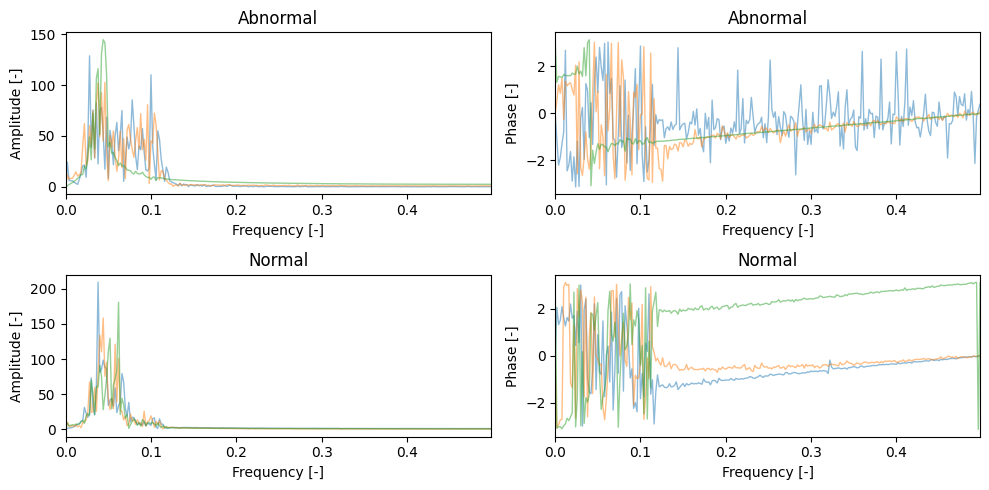

In [70]:
import matplotlib.pyplot as plt
import numpy as np

fig,axes = plt.subplots(nrows=len(CLASS_NAMES),ncols=2,figsize=(10,5))
for i in range(len(axes)):
    for j in range(3):
        index = np.where(y_test == i)[0][j]
        fft = np.fft.fft(np.array(X_test[index], dtype=float))
        freq = np.fft.fftfreq(fft.shape[-1])
        fft = fft[freq >= 0]
        freq = freq[freq >= 0]
        amplitude = (fft.real**2 + fft.imag**2)**.5
        phase = np.arctan2(fft.imag, fft.real)
        
        axes[i][0].plot(freq, amplitude, linewidth=1, alpha=0.5)
        axes[i][1].plot(freq, phase, linewidth=1, alpha=0.5)
    for j in range(2):
        axes[i][j].set_title(f"{CLASS_NAMES[i]}")
        axes[i][j].set_xlabel("Frequency [-]")
        axes[i][j].set_xlim(0, freq.max())
    axes[i][0].set_ylabel("Amplitude [-]")
    axes[i][1].set_ylabel("Phase [-]")
    #ax.set_ylim(-4, 4)

plt.tight_layout()
plt.show()

### Klasyfikacja

In [71]:
def get_fft_amplitude(data: np.ndarray) -> np.ndarray:
    fft = np.abs(np.fft.fft(data))
    fft = fft[fft.shape[-1]//2:]
    return (fft.real**2 + fft.imag**2)**.5

In [72]:
from sklearn.preprocessing import FunctionTransformer

def extract_fft_features(input_series: np.ndarray) -> np.ndarray:
    return np.array([get_fft_amplitude(vec) for vec in input_series], dtype=np.float64)


fft_features = FunctionTransformer(extract_fft_features)

In [73]:
# Stworzenie pipeline'u
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# SVM
from sklearn.svm import SVC
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# KNN
from sklearn.neighbors import KNeighborsClassifier

if USE_FFT:
    pipeline_SVM = Pipeline([
        ('feature_extractor', fft_features),
        ('scaler', StandardScaler()),
        ('model', SVC(kernel='rbf'))
    ])

    pipeline_RF = Pipeline([
        ('feature_extractor', fft_features),
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier())
    ])

    pipeline_KNN = Pipeline([
        ('feature_extractor', fft_features),
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier())
    ])
else:
    pipeline_SVM = Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(kernel='rbf'))
    ])

    pipeline_RF = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier())
    ])

    pipeline_KNN = Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier())
    ])


In [74]:
pipeline_SVM.fit(X_train, y_train)

Pipeline(steps=[('feature_extractor',
                 FunctionTransformer(func=<function extract_fft_features at 0x0000027C66292DE0>)),
                ('scaler', StandardScaler()), ('model', SVC())])

In [75]:
pipeline_RF.fit(X_train, y_train)

Pipeline(steps=[('feature_extractor',
                 FunctionTransformer(func=<function extract_fft_features at 0x0000027C66292DE0>)),
                ('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

In [76]:
pipeline_KNN.fit(X_train, y_train)

Pipeline(steps=[('feature_extractor',
                 FunctionTransformer(func=<function extract_fft_features at 0x0000027C66292DE0>)),
                ('scaler', StandardScaler()),
                ('model', KNeighborsClassifier())])

              precision    recall  f1-score   support

    Abnormal      0.937     0.943     0.940       681
      Normal      0.939     0.933     0.936       639

    accuracy                          0.938      1320
   macro avg      0.938     0.938     0.938      1320
weighted avg      0.938     0.938     0.938      1320



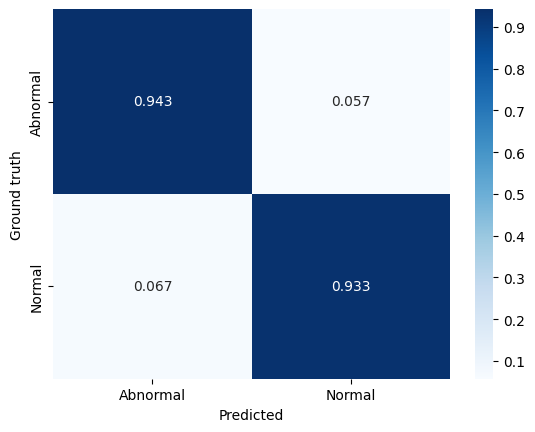

In [77]:
# Evaluate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

preds_svm = pipeline_SVM.predict(X_test)

report_svm = classification_report(y_test, preds_svm, target_names=CLASS_NAMES, zero_division=0, digits=3)
print(report_svm)

confusion_matrix_svm = confusion_matrix(y_test, preds_svm)
confusion_matrix_svm = confusion_matrix_svm / confusion_matrix_svm[:, :].sum(axis=1)[:, np.newaxis]
ax = heatmap(confusion_matrix_svm, annot=True, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues', fmt=".3f")
ax.set_xlabel("Predicted") 
ax.set_ylabel("Ground truth")
plt.show()

              precision    recall  f1-score   support

    Abnormal      0.943     0.916     0.929       681
      Normal      0.913     0.941     0.927       639

    accuracy                          0.928      1320
   macro avg      0.928     0.928     0.928      1320
weighted avg      0.928     0.928     0.928      1320



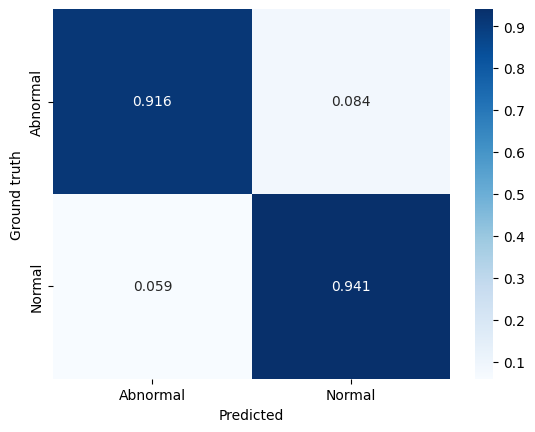

In [78]:
preds_rf = pipeline_RF.predict(X_test)

report_rf = classification_report(y_test, preds_rf, target_names=CLASS_NAMES, zero_division=0, digits=3)
print(report_rf)

confusion_matrix_rf = confusion_matrix(y_test, preds_rf)
confusion_matrix_rf = confusion_matrix_rf / confusion_matrix_rf[:, :].sum(axis=1)[:, np.newaxis]
ax = heatmap(confusion_matrix_rf, annot=True, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues', fmt=".3f")
ax.set_xlabel("Predicted") 
ax.set_ylabel("Ground truth")
plt.show()

              precision    recall  f1-score   support

    Abnormal      0.863     0.915     0.888       681
      Normal      0.903     0.845     0.873       639

    accuracy                          0.881      1320
   macro avg      0.883     0.880     0.881      1320
weighted avg      0.882     0.881     0.881      1320



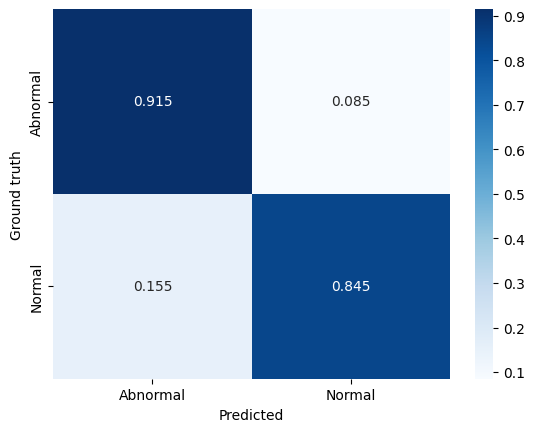

In [79]:
preds_knn = pipeline_KNN.predict(X_test)

report_knn = classification_report(y_test, preds_knn, target_names=CLASS_NAMES, zero_division=0, digits=3)
print(report_knn)

confusion_matrix_knn = confusion_matrix(y_test, preds_knn)
confusion_matrix_knn = confusion_matrix_knn / confusion_matrix_knn[:, :].sum(axis=1)[:, np.newaxis]
ax = heatmap(confusion_matrix_knn, annot=True, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues', fmt=".3f")
ax.set_xlabel("Predicted") 
ax.set_ylabel("Ground truth")
plt.show()

### Wykorzystanie CNN

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Stworzenie datasetu i dataloadera

In [81]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

# Dataset
class CustomDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        if USE_FFT:
            X = np.array([get_fft_amplitude(vec) for vec in X], dtype=np.float64)

        # Add channel dimension
        X = np.expand_dims(X, axis=1) # N x C x L, with C=1
        # Standarize
        X = (X - np.mean(X)) / np.std(X)

        self.X = torch.tensor(X.astype(np.float32))
        self.y = torch.tensor(y.astype(np.int64))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def get_class_weights(self):
        class_sample_count = np.unique(self.y.numpy(), return_counts=True)[1]
        weight = (np.sum(class_sample_count) / class_sample_count).astype(np.float32)
        return torch.from_numpy(weight)

class CustomDataloader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle, augment: bool = False):
        super().__init__(dataset, batch_size, shuffle)
        self.augment = augment

    def __iter__(self):
        for batch in super().__iter__():
            if self.augment:
                batch = self.augment_batch(batch)
            yield batch

    def augment_batch(self, batch):
        data,labels = batch
        for i in range(len(data)):
            # Add offset
            data[i] = data[i] + torch.rand(1)*0.1

        return [data,labels]

# Dataloaders
dataset_train = CustomDataset(X_train, y_train)
dataloader_train = CustomDataloader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, augment=True)

dataset_test = CustomDataset(X_test, y_test)
dataloader_test = CustomDataloader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, augment=False)

print(dataset_train.get_class_weights())

tensor([1.9507, 2.0519])


### Definicja własnej sieci neuronowej

https://journals.sagepub.com/doi/full/10.3233/ICA-200617

In [82]:
class CNN(nn.Module):
    def __init__(self, n_class: int, n_channels_in: int) -> None:
        super().__init__()

        CHANNELS_0 = 32
        CHANNELS_1 = 64
        CHANNELS_2 = 128
        NEURONS_0 = 512
        NEURONS_1 = 128

        self.conv0 = nn.Sequential(
            nn.Conv1d(n_channels_in, out_channels=CHANNELS_0, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        self.conv1 = nn.Sequential(
            nn.Conv1d(CHANNELS_0, out_channels=CHANNELS_1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(CHANNELS_1, out_channels=CHANNELS_2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        
        self.fc0 = nn.Sequential(
            nn.Linear(CHANNELS_2, NEURONS_0),
            nn.ReLU()
        )

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Sequential(
            nn.Linear(NEURONS_0, NEURONS_1),
            nn.ReLU()
        )

        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Sequential(
            nn.Linear(NEURONS_1, n_class),
            #nn.Softmax(dim=1)
        )

        
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:

        out = self.conv0(x)
        out = self.conv1(out)
        out = self.conv2(out)

        # Global max pooling
        out = torch.max(out, dim=2).values


        out = self.fc0(out)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

    def print_data_shapes(self, input_length: int) -> None:

        x = torch.randn(1, 1, input_length).to(next(self.parameters()).device)
        print(f"Input shape: {x.shape[1:]}")

        out = self.conv0(x)
        print(f"Conv0 shape: {out.shape[1:]}")

        out = self.conv1(out)
        print(f"Conv1 shape: {out.shape[1:]}")

        out = self.conv2(out)
        print(f"Conv2 shape: {out.shape[1:]}")

        out = torch.max(out, dim=2).values
        print(f"Global max pooling shape: {out.shape}")

        out = self.fc0(out)
        print(f"FC0 shape: {out.shape[1:]}")

        out = self.fc1(out)
        print(f"FC1 shape: {out.shape[1:]}")

        out = self.fc2(out)
        print(f"FC2 shape: {out.shape[1:]}")
    
    def get_conv_embedding(self, x: torch.Tensor) -> torch.Tensor:

        out = self.conv0(x)
        out = self.conv1(out)
        out = self.conv2(out)

        # Global max pooling
        out = torch.max(out, dim=2).values

        return out
    
    def get_fc_embedding(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv0(x)
        out = self.conv1(out)
        out = self.conv2(out)

        # Global max pooling
        out = torch.max(out, dim=2).values


        out = self.fc0(out)
        out = self.dropout(out)
        out = self.fc1(out)
        
        return out
    
    def predict(self, X):
        self.eval()
        with torch.no_grad():
            pred = self(X).argmax(dim=1)
        return pred

In [83]:
from torch.cuda import is_available

iscuda = True if is_available() else False
if iscuda: print(torch.cuda.get_device_name(0))

In [84]:
model_cnn = CNN(len(CLASS_NAMES), 1)
if iscuda: model_cnn = model_cnn.cuda()

In [85]:
model_cnn.print_data_shapes(X_train.shape[1])

Input shape: torch.Size([1, 500])
Conv0 shape: torch.Size([32, 250])
Conv1 shape: torch.Size([64, 125])
Conv2 shape: torch.Size([128, 62])
Global max pooling shape: torch.Size([1, 128])
FC0 shape: torch.Size([512])
FC1 shape: torch.Size([128])
FC2 shape: torch.Size([2])


### Training ResNet

In [86]:
def plot_loss(train_loss, val_loss, val_accuracy, save_name):

    fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

    
    axes[0].plot(val_loss, marker='.', label='Validation', linewidth=.5)
    axes[0].plot(train_loss, marker='.', label='Train', linewidth=.5)
    axes[1].plot(val_accuracy, marker='.', label='Validation', linewidth=.5)

    axes[0].legend()
    axes[1].legend()

    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")

    fig.tight_layout()
    
    fig.savefig(save_name, dpi=300, bbox_inches='tight')

    plt.show()

In [87]:
from torch import optim
from tqdm import tqdm

def train(model, save_name, epochs=5):

    class_weights = dataset_train.get_class_weights().to('cuda' if iscuda else 'cpu')
    criterion = nn.CrossEntropyLoss(weight=class_weights) # Important - class imbalance!
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(epochs):
        
        model.train()
        losses = []
        
        for i, (inputs, labels) in tqdm(enumerate(dataloader_train, 0),desc=f"[{epoch + 1}/{epochs}] Training"):
            inputs = inputs.to('cuda' if iscuda else 'cpu')
            labels = labels.to('cuda' if iscuda else 'cpu')
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        train_loss.append(np.mean(losses))

        # validation loss
        model.eval()
        losses = []
        correct_preds = 0
        
        for i, (inputs, labels) in tqdm(enumerate(dataloader_test),desc=f"[{epoch + 1}/{epochs}] Validation"):
            inputs = inputs.to('cuda' if iscuda else 'cpu')
            labels = labels.to('cuda' if iscuda else 'cpu')

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            correct_preds += (outputs.argmax(dim=1) == labels).float().mean().item()

        val_accuracy.append(correct_preds/len(dataloader_test))
        val_loss.append(np.mean(losses))
        
        # print loss
        print(f'\ttrain loss: {train_loss[-1]:.4f} | val loss: {val_loss[-1]:.4f}| val acc.: {val_accuracy[-1]*100.0:.2f}\n')

    torch.save(model.state_dict(), save_name)

    return train_loss, val_loss, val_accuracy

In [ ]:
train_loss, val_loss, val_accuracy = train(model_cnn, 'model_cnn.pth', epochs=25)

[1/25] Training: 113it [00:01, 87.13it/s]
[1/25] Validation: 42it [00:00, 274.04it/s]


	train loss: 0.6813 | val loss: 0.6491| val acc.: 62.13



[2/25] Training: 113it [00:01, 89.40it/s]
[2/25] Validation: 42it [00:00, 276.84it/s]


	train loss: 0.5752 | val loss: 0.4972| val acc.: 78.05



[3/25] Training: 113it [00:01, 86.45it/s]
[3/25] Validation: 42it [00:00, 256.34it/s]


	train loss: 0.4398 | val loss: 0.4012| val acc.: 84.67



[4/25] Training: 113it [00:01, 87.40it/s]
[4/25] Validation: 42it [00:00, 278.18it/s]


	train loss: 0.3625 | val loss: 0.4095| val acc.: 81.99



[5/25] Training: 113it [00:01, 89.31it/s]
[5/25] Validation: 42it [00:00, 282.22it/s]


	train loss: 0.3094 | val loss: 0.2985| val acc.: 89.29



[6/25] Training: 113it [00:01, 84.94it/s]
[6/25] Validation: 42it [00:00, 283.46it/s]


	train loss: 0.2669 | val loss: 0.2632| val acc.: 90.92



[7/25] Training: 113it [00:01, 84.89it/s]
[7/25] Validation: 42it [00:00, 277.18it/s]


	train loss: 0.2416 | val loss: 0.2562| val acc.: 91.29



[8/25] Training: 113it [00:01, 88.62it/s]
[8/25] Validation: 42it [00:00, 279.99it/s]


	train loss: 0.2280 | val loss: 0.2320| val acc.: 91.52



[9/25] Training: 113it [00:01, 86.62it/s]
[9/25] Validation: 42it [00:00, 282.85it/s]


	train loss: 0.2124 | val loss: 0.2259| val acc.: 91.67



[10/25] Training: 113it [00:01, 90.03it/s]
[10/25] Validation: 42it [00:00, 282.22it/s]


	train loss: 0.1966 | val loss: 0.2374| val acc.: 90.77



[11/25] Training: 113it [00:01, 90.16it/s]
[11/25] Validation: 42it [00:00, 282.24it/s]


	train loss: 0.2036 | val loss: 0.2202| val acc.: 92.34



[12/25] Training: 113it [00:01, 87.64it/s]
[12/25] Validation: 42it [00:00, 278.74it/s]


	train loss: 0.1892 | val loss: 0.2320| val acc.: 91.89



[13/25] Training: 113it [00:01, 87.87it/s]
[13/25] Validation: 42it [00:00, 282.45it/s]


	train loss: 0.1807 | val loss: 0.2010| val acc.: 92.11



[14/25] Training: 9it [00:00, 87.42it/s]

In [ ]:
plot_loss(train_loss, val_loss, val_accuracy, 'model_cnn.png')

In [ ]:
def predict_test(model):
    predictions, labels = [], []
    for i, (input, label) in tqdm(enumerate(dataloader_test),desc=f"| Validation"):
        input = input.to('cuda' if iscuda else 'cpu')
        label = label.to('cuda' if iscuda else 'cpu')
        
        predictions += model.predict(input).detach().cpu().numpy().tolist()
        labels += label.detach().cpu().numpy().tolist()
    return predictions, labels

preds_cnn, labels_cnn = predict_test(model_cnn)

In [ ]:
report_cnn = classification_report(labels_cnn, preds_cnn, target_names=CLASS_NAMES, zero_division=0, digits=3)
print(report_cnn)

In [ ]:
confusion_matrix_cnn = confusion_matrix(labels_cnn, preds_cnn)
confusion_matrix_cnn = confusion_matrix_cnn / confusion_matrix_cnn[:, :].sum(axis=1)[:, np.newaxis]
ax = heatmap(confusion_matrix_cnn, annot=True, xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues', fmt=".3f")
ax.set_xlabel("Predicted") 
ax.set_ylabel("Ground truth")
plt.show()

### Analiza cech głębokich

In [ ]:
def extract_features_conv(model):
    features, labels = [], []
    for i, (input, label) in tqdm(enumerate(dataloader_test),desc=f"| Extracting features"):
        input = input.to('cuda' if iscuda else 'cpu')
        label = label.to('cuda' if iscuda else 'cpu')
        
        features += model.get_conv_embedding(input).detach().cpu().numpy().tolist()
        labels += label.detach().cpu().numpy().tolist()
    return np.array(features), np.array(labels)

def extract_features_linear(model):
    features, labels = [], []
    for i, (input, label) in tqdm(enumerate(dataloader_test),desc=f"| Extracting features"):
        input = input.to('cuda' if iscuda else 'cpu')
        label = label.to('cuda' if iscuda else 'cpu')
        
        features += model.get_fc_embedding(input).detach().cpu().numpy().tolist()
        labels += label.detach().cpu().numpy().tolist()
    return np.array(features), np.array(labels)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_features(features, labels, save_name):
        
    tsne = TSNE(n_components=2, random_state=0, perplexity=40)
    pca = PCA(n_components=2)

    X_tsne = tsne.fit_transform(features)
    X_pca = pca.fit_transform(features)

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

    for i, ax in enumerate(axes):
        for j in range(len(CLASS_NAMES)):
            index = np.where(labels == j)[0]
            if i == 0:
                ax.scatter(X_tsne[index, 0], X_tsne[index, 1], label=CLASS_NAMES[j], marker='.', color='crimson' if j == 0 else 'royalblue')
            else:
                ax.scatter(X_pca[index, 0], X_pca[index, 1], label=CLASS_NAMES[j], marker='.', color='crimson' if j == 0 else 'royalblue')
        ax.legend()
        ax.set_xlabel(f"PC1 {pca.explained_variance_ratio_[0]*100:.2f}%" if i == 1 else "t-SNE 1")
        ax.set_ylabel(f"PC1 {pca.explained_variance_ratio_[1]*100:.2f}%" if i == 1 else "t-SNE 2")

    fig.tight_layout()

    fig.savefig(save_name, dpi=300, bbox_inches='tight')

    plt.show()

In [ ]:
features, labels = extract_features_conv(model_cnn)
plot_features(features, labels, 'features_cnn_1.png')

In [ ]:
features, labels = extract_features_linear(model_cnn)
plot_features(features, labels, 'features_cnn_2.png')